# Импорт библиотек

In [38]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Настройка CometML
<img src='https://camo.githubusercontent.com/b35adf34bc440ea2ac19bb0d3432f48e26d71ab8e4c256e936b709eec44f5b19/68747470733a2f2f7777772e636f6d65742e6d6c2f696d616765732f6c6f676f5f636f6d65745f6c696768742e706e67' width=500px>

In [39]:
#!pip install comet_ml

In [40]:
from comet_ml import Experiment

In [41]:
# импорт закрытого ключа
import os
from dotenv import load_dotenv

dotenv_path = os.path.join(os.getcwd(), '.env')
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)
# Получение токена из конфигурационного файла
API_COMET = os.environ["API_COMET"]

In [42]:
# Создайте эксперимент с помощью вашего API ключа
experiment = Experiment(
    api_key=API_COMET,
    project_name='medical-appointment',
    workspace='al-ogr',
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/al-ogr/medical-appointment/b22025d3ee0544e489102067867d2749



# Загрузка данных

In [43]:
df = pd.read_csv('./data/KaggleV2-May-2016.csv')

In [44]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# Визуализация

### Распределение числовых признаков

{'web': 'https://www.comet.com/api/image/download?imageId=af4f3100acab4145b99e9b1aa3bca81c&experimentKey=b22025d3ee0544e489102067867d2749',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=af4f3100acab4145b99e9b1aa3bca81c&experimentKey=b22025d3ee0544e489102067867d2749',
 'imageId': 'af4f3100acab4145b99e9b1aa3bca81c'}

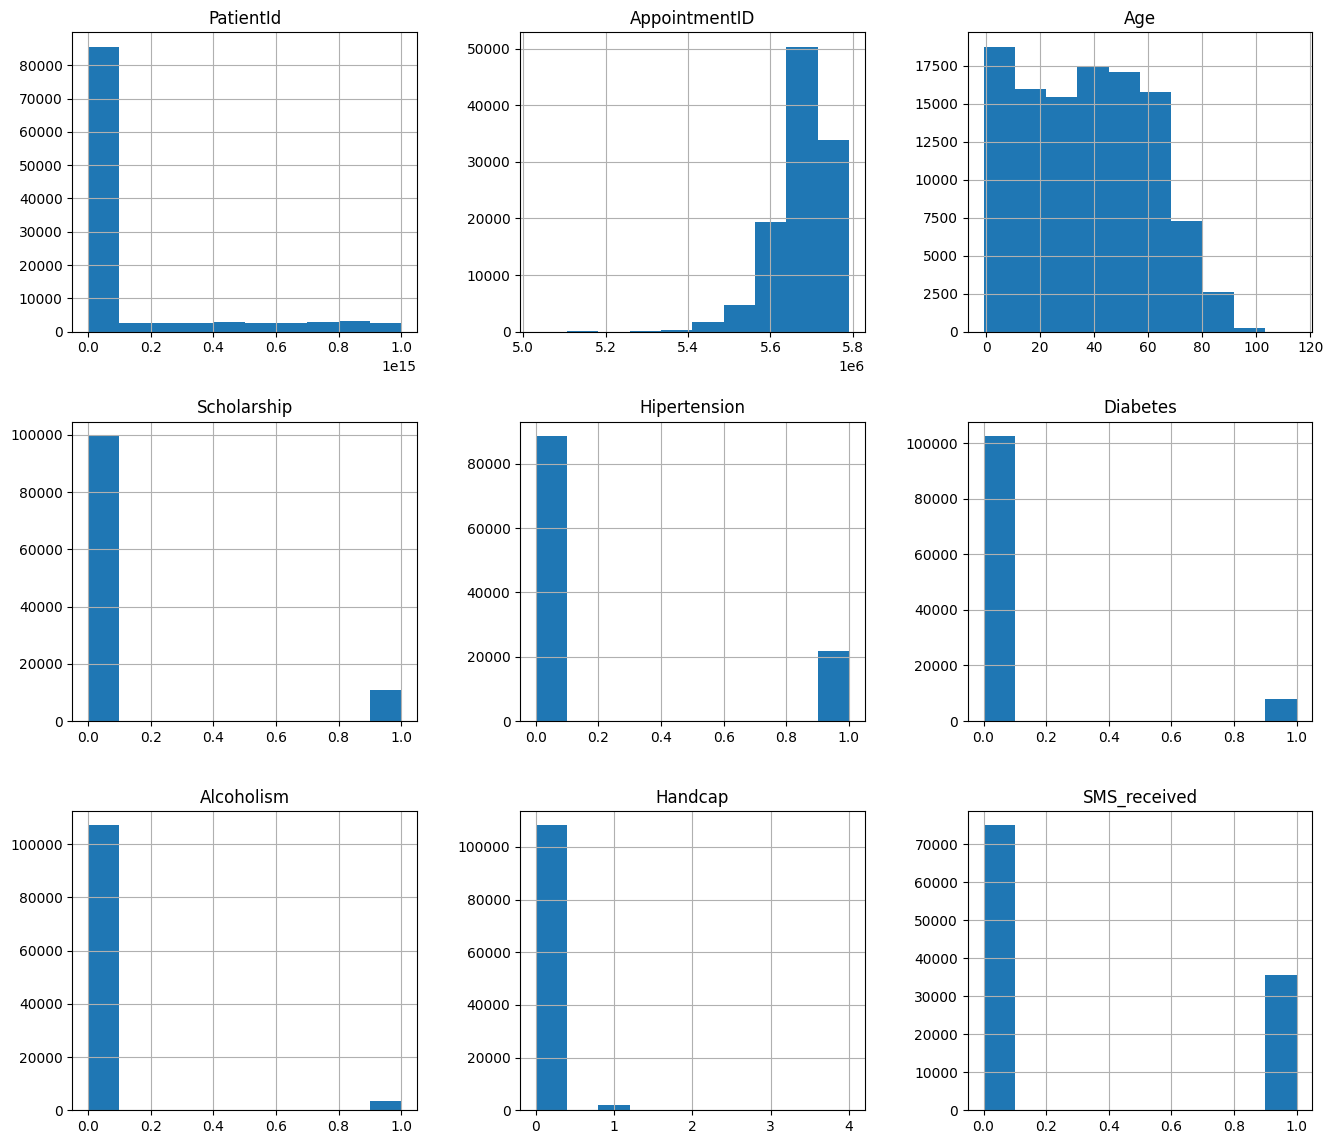

In [45]:
df.hist(figsize=(16,14));
#логируем гистограмму
experiment.log_figure(figure=plt)

*Проанализируем число людей каждого возраста*

In [46]:
print("Уникальные значения в `Age` => {}".format(df.Age.unique()))

Уникальные значения в `Age` => [ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35  20
  26  34  33  16  42   5  47  17  41  44  37  24  66  77  81  70  53  75
  73  52  74  43  89  57  14   9  48  83  72  25  80  87  88  84  82  90
  94  86  91  98  92  96  93  95  97 102 115 100  99  -1]


In [47]:
# Удалим аномальные значения
df = df[(df.Age >= 0) & (df.Age <= 110)]
df.Age.value_counts()

Age
0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
97       11
98        6
100       4
102       2
99        1
Name: count, Length: 102, dtype: int64

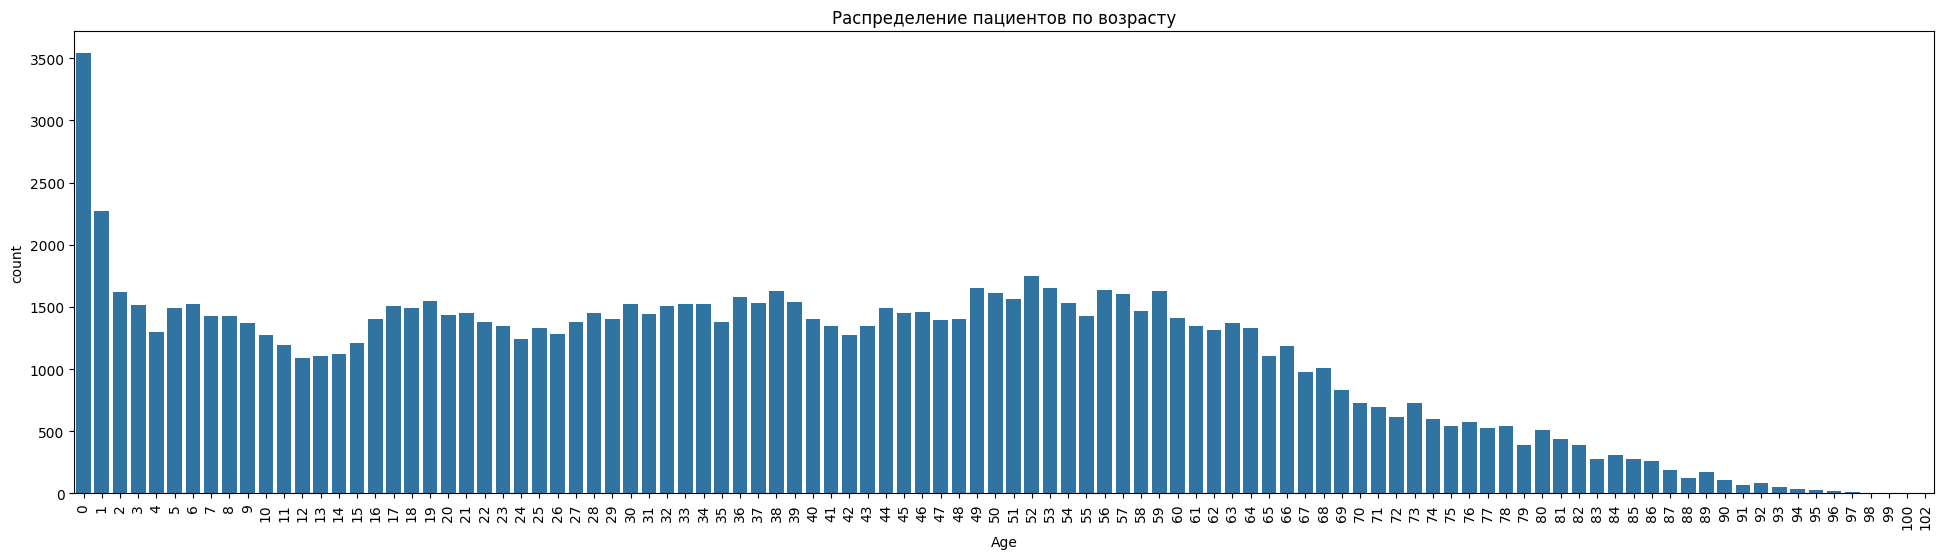

In [48]:
plt.figure(figsize=(24,6))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age)
ax.set_title("Распределение пациентов по возрасту")
experiment.log_figure(figure=plt)
plt.show()

### Корреляция между числовыми признаками, отобранными для обучения модели

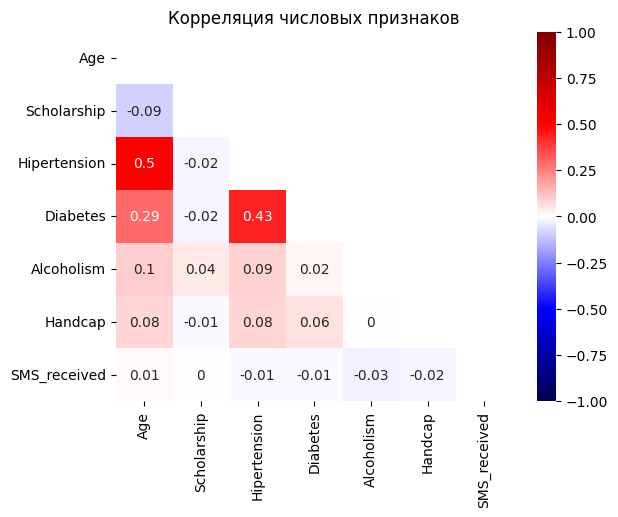

In [49]:
# Отбор данных
show_data = df.drop(['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay', 'No-show'], axis=1)
# Визуализация корреляции числовых признаков через тепловую карту
ax = plt.axes()
sns.heatmap(show_data.corr(numeric_only=True).round(2), 
            annot = True, # Подпись значений
            vmin=-1, 
            vmax=1, 
            center= 0, 
            cmap= 'seismic',
            mask=np.triu(show_data.corr(numeric_only=True))) # Маска отображения
ax.set_title('Корреляция числовых признаков')
#логируем тепловую карту
experiment.log_figure(figure=plt)
plt.show()

# Придет ли пациент на назначенный прием? 

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110521 non-null  float64
 1   AppointmentID   110521 non-null  int64  
 2   Gender          110521 non-null  object 
 3   ScheduledDay    110521 non-null  object 
 4   AppointmentDay  110521 non-null  object 
 5   Age             110521 non-null  int64  
 6   Neighbourhood   110521 non-null  object 
 7   Scholarship     110521 non-null  int64  
 8   Hipertension    110521 non-null  int64  
 9   Diabetes        110521 non-null  int64  
 10  Alcoholism      110521 non-null  int64  
 11  Handcap         110521 non-null  int64  
 12  SMS_received    110521 non-null  int64  
 13  No-show         110521 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 12.6+ MB


## Кодировка категориальных признаков

In [51]:
categorical_columns_names = ['Gender', 'Neighbourhood']

In [52]:
encoded_columns = pd.get_dummies(df, columns = categorical_columns_names)

In [53]:
encoded_columns.drop(['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay', 'No-show'], axis=1, inplace = True)

In [54]:
encoded_columns.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Gender_F,Gender_M,Neighbourhood_AEROPORTO,...,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,62,0,1,0,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,56,0,0,0,0,0,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,62,0,0,0,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,8,0,0,0,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,56,0,1,1,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [55]:
y = df['No-show']

In [56]:
y

0         No
1         No
2         No
3         No
4         No
          ..
110522    No
110523    No
110524    No
110525    No
110526    No
Name: No-show, Length: 110521, dtype: object

In [57]:
y = y.replace({'No': 0, 'Yes': 1})

C:\Users\g-022\AppData\Local\Temp\ipykernel_12072\3050984062.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'No': 0, 'Yes': 1})


In [58]:
y.value_counts(True)

No-show
0    0.798084
1    0.201916
Name: proportion, dtype: float64

## Шкалирование данных

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
scaler = MinMaxScaler()
X = scaler.fit_transform(encoded_columns)

In [61]:
print(X.shape)

(110521, 90)


# Модель (этот раздел будет подробно изучен далее в курсе)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Инициализация модели

In [63]:
logreg = LogisticRegression()

In [64]:
random_state = 42

### Обучение модели

In [65]:
logreg.fit(X, y)

LogisticRegression()

#### Логирование параметров обучения

In [66]:
params={"random_state":random_state,
        "model_type":"logreg"
}

In [67]:
experiment.log_parameters(params)

### Предсказания модели

In [68]:
y_pred = logreg.predict(X)

### Анализ модели

In [69]:
accuracy = accuracy_score(y, y_pred)

print("Доля правильных ответов: {:6.3f}".format(accuracy))

Доля правильных ответов:  0.798


# Логирование метрик

In [70]:
metrics = {"accuracy":accuracy}

In [71]:
experiment.log_metrics(metrics)

<img src='https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@r2yYhe2DpE4d3WKP.png' width=700px>

In [72]:
experiment.log_confusion_matrix(y.tolist(), y_pred.tolist())

{'web': 'https://www.comet.com/api/asset/download?assetId=a5de4cd5cdd342bdaf1f460592ddfa20&experimentKey=b22025d3ee0544e489102067867d2749',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=a5de4cd5cdd342bdaf1f460592ddfa20&experimentKey=b22025d3ee0544e489102067867d2749',
 'assetId': 'a5de4cd5cdd342bdaf1f460592ddfa20'}

In [73]:
experiment.display()

In [74]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : notable_mite_9416
COMET INFO:     url                   : https://www.comet.com/al-ogr/medical-appointment/b22025d3ee0544e489102067867d2749
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.7980836221170637
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : None
COMET INFO:     clip              : False
COMET INFO:     copy              : True
COMET INFO:     dual              : False
COMET INFO:     feature_range     : (0, 1)
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : None
COMET INFO:     max_iter          : 100
COMET INFO:   

# Домашнее задание

Визуализируйте корреляцию между числовыми признаками, использованными для обучения модели и залогируйте изображение в Comet.

В качестве ответа приложите обновленный ноутбук.

*Форма оценки ментором:*

1) Проведена визуализация корреляции между 7 числовыми признаками, использованными для обучения модели - 5 баллов

2) Произведено логирование графика в CometMl - 10 баллов

